# Telecom Churn Analysis and Prediction

In [1]:
import os, sys

import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Included changes to make the kernel run as a jupyter notebook on windows without the need to make any changes
kaggle_data_folder = os.path.join('kaggle', 'input') if sys.platform == 'win32' else os.path.join(os.path.sep, 'kaggle', 'input')
file_ext = ".csv"
files = []
for dirname, _, filenames in os.walk(kaggle_data_folder):
    for filename in filenames:
        if filename.endswith(file_ext):
            files.append(os.path.join(dirname, filename))

print(files)
# Any results you write to the current directory are saved as output.

['/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv']


In [2]:
from fastai.imports import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

<a id="import-and-clean-data"></a>
# 1.  Import and Clean data

In [3]:
df = pd.read_csv(files[0])
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


<a id="delete-%60customerid%60-column"></a>
## 1.1.  Delete `customerid` column
Since 'customerid' column does not provide any relevant information in predicting the customer churn, we can delete the column.

In [4]:
df.drop(labels=['customerID'], axis=1, inplace=True)
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


<a id="data-munging"></a>
## 1.2.  Data Munging

<a id="checking-for-null-values-in-the-dataset"></a>
### 1.2.1.  Checking for null values in the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


As of now we don't see any null values. However, we will find a few in the `TotalCharges` column after casting it to `float64`

<a id="making-labels-concise"></a>
### 1.2.2.  Making labels concise
Let's make the categorical labels more concise. For instance, we will convert the categorical label `'Bank transfer (automatic)'` to `'Bank transfer'` to make it easier to access (and display) during visualization.

In [6]:
## Shorten the Labels
value_mapper = {'Female': 'F', 'Male': 'M', 'Yes': 'Y', 'No': 'N',
                'No phone service': 'No phone', 'Fiber optic': 'Fiber',
                'No internet service': 'No internet', 'Month-to-month': 'Monthly',
                'Bank transfer (automatic)': 'Bank transfer',
                'Credit card (automatic)': 'Credit card',
                'One year': '1 yr', 'Two year': '2 yr'}
df.replace(to_replace=value_mapper, inplace=True)
# Another method
# df = df.applymap(lambda v: value_mapper[v] if v in value_mapper.keys() else v)

Let's also change column labels from `TitleCase` to `lowercase` to ease access.

In [7]:
df.columns = [label.lower() for label in df.columns]
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
gender,F,M,M,M,F,F,M,F,F,M
seniorcitizen,0,0,0,0,0,0,0,0,0,0
partner,Y,N,N,N,N,N,N,N,Y,N
dependents,N,N,N,N,N,N,Y,N,N,Y
tenure,1,34,2,45,2,8,22,10,28,62
phoneservice,N,Y,Y,N,Y,Y,Y,N,Y,Y
multiplelines,No phone,N,N,No phone,N,Y,Y,No phone,Y,N
internetservice,DSL,DSL,DSL,DSL,Fiber,Fiber,Fiber,DSL,Fiber,DSL
onlinesecurity,N,Y,Y,Y,N,N,N,Y,N,Y
onlinebackup,Y,N,Y,N,N,N,Y,N,N,Y


<a id="column-type-casting-and-imputation"></a>
### 1.2.3.  Column Type Casting and Imputation
Pandas couldn't properly cast the data type of several columns. For instance, the `TotalCharges` column is recognized as `object` instead of `float`. Similarly, all the categorical columns were casted as `object` type instead of `pd.Categorical`.

<a id="cast-%60totalcharges%60-column-to-%60float%60"></a>
#### 1.2.3.1.  Cast `TotalCharges` column to `float`

In [8]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: totalcharges, dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   multiplelines     7043 non-null   object 
 7   internetservice   7043 non-null   object 
 8   onlinesecurity    7043 non-null   object 
 9   onlinebackup      7043 non-null   object 
 10  deviceprotection  7043 non-null   object 
 11  techsupport       7043 non-null   object 
 12  streamingtv       7043 non-null   object 
 13  streamingmovies   7043 non-null   object 
 14  contract          7043 non-null   object 
 15  paperlessbilling  7043 non-null   object 
 16  paymentmethod     7043 non-null   object 


Here we see that the `totalcharges` has 11 missing values. Let's see the complete data corresponding to these customers.

In [10]:
df[np.isnan(df['totalcharges'])]

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
488,F,0,Y,Y,0,N,No phone,DSL,Y,N,Y,Y,Y,N,2 yr,Y,Bank transfer,52.55,NaN,N
753,M,0,N,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,20.25,NaN,N
936,F,0,Y,Y,0,Y,N,DSL,Y,Y,Y,N,Y,Y,2 yr,N,Mailed check,80.85,NaN,N
1082,M,0,Y,Y,0,Y,Y,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,25.75,NaN,N
1340,F,0,Y,Y,0,N,No phone,DSL,Y,Y,Y,Y,Y,N,2 yr,N,Credit card,56.05,NaN,N
3331,M,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,19.85,NaN,N
3826,M,0,Y,Y,0,Y,Y,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,25.35,NaN,N
4380,F,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,2 yr,N,Mailed check,20.00,NaN,N
5218,M,0,Y,Y,0,Y,N,N,No internet,No internet,No internet,No internet,No internet,No internet,1 yr,Y,Mailed check,19.70,NaN,N
6670,F,0,Y,Y,0,Y,Y,DSL,N,Y,Y,Y,Y,N,2 yr,N,Mailed check,73.35,NaN,N


It can also be noted that the `Tenure` column is 0 for these entries even though the `monthlycharges` column is not empty. Let's see if there are any other 0 values in the `tenure` column.

In [11]:
df[df['tenure'] == 0].index

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

There are no additional missing values in the `Tenure` column. Let's delete the rows with missing values in `monthlycharges` and `tenure` columns.

In [12]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Int64Index([], dtype='int64')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   seniorcitizen     7032 non-null   int64  
 2   partner           7032 non-null   object 
 3   dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   phoneservice      7032 non-null   object 
 6   multiplelines     7032 non-null   object 
 7   internetservice   7032 non-null   object 
 8   onlinesecurity    7032 non-null   object 
 9   onlinebackup      7032 non-null   object 
 10  deviceprotection  7032 non-null   object 
 11  techsupport       7032 non-null   object 
 12  streamingtv       7032 non-null   object 
 13  streamingmovies   7032 non-null   object 
 14  contract          7032 non-null   object 
 15  paperlessbilling  7032 non-null   object 
 16  paymentmethod     7032 non-null   object 


<a id="search-for-categorical-columns-and-cast-them-to-%60pd.categorical%60"></a>
#### 1.2.3.2.  Search for categorical columns and cast them to `pd.Categorical`
We need to manually identify categorical columns in the data before casting them to `pd.Categorical`. Casting categorical columns from the detected *object* type to *categorical* will ease visualization.

In [14]:
def summarize_categoricals(df, show_levels=False):
    """
        Display uniqueness in each column
    """
    data = [[df[c].unique(), len(df[c].unique()), df[c].isnull().sum()] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                           columns=['Levels', 'No. of Levels', 'No. of Missing Values'])
    return df_temp.iloc[:, 0 if show_levels else 1:]


def find_categorical(df, cutoff=10):
    """
        Function to find categorical columns in the dataframe.
    """
    cat_cols = []
    for col in df.columns:
        if len(df[col].unique()) <= cutoff:
            cat_cols.append(col)
    return cat_cols


def to_categorical(columns, df):
    """
        Converts the columns passed in `columns` to categorical datatype
    """
    for col in columns:
        df[col] = df[col].astype('category')
    return df

In [15]:
summarize_categoricals(df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values
gender,"[F, M]",2,0
seniorcitizen,"[0, 1]",2,0
partner,"[Y, N]",2,0
dependents,"[N, Y]",2,0
tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",72,0
phoneservice,"[N, Y]",2,0
multiplelines,"[No phone, N, Y]",3,0
internetservice,"[DSL, Fiber, N]",3,0
onlinesecurity,"[N, Y, No internet]",3,0
onlinebackup,"[Y, N, No internet]",3,0


In [16]:
df = to_categorical(find_categorical(df), df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   seniorcitizen     7032 non-null   category
 2   partner           7032 non-null   category
 3   dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   phoneservice      7032 non-null   category
 6   multiplelines     7032 non-null   category
 7   internetservice   7032 non-null   category
 8   onlinesecurity    7032 non-null   category
 9   onlinebackup      7032 non-null   category
 10  deviceprotection  7032 non-null   category
 11  techsupport       7032 non-null   category
 12  streamingtv       7032 non-null   category
 13  streamingmovies   7032 non-null   category
 14  contract          7032 non-null   category
 15  paperlessbilling  7032 non-null   category
 16  paymentmethod     7032 n

<a id="reordering-columns"></a>
### 1.2.4.  Reordering Columns

In [17]:
new_order = list(df.columns)
new_order.insert(16, new_order.pop(4))
df = df[new_order]
df.head(2)

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,tenure,monthlycharges,totalcharges,churn
0,F,0,Y,N,N,No phone,DSL,N,Y,N,N,N,N,Monthly,Y,Electronic check,1,29.85,29.85,N
1,M,0,N,N,Y,N,DSL,Y,N,Y,N,N,N,1 yr,N,Mailed check,34,56.95,1889.50,N


<a id="correlations-in-the-data"></a>
# 2.  Correlations in the data

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthlycharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
totalcharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


<a id="correlation-between-quantitative-variables"></a>
## 2.1.  Correlation between Quantitative variables

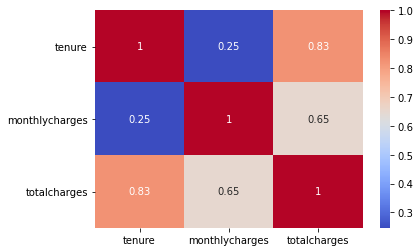

In [19]:
sns.heatmap(data=df[['tenure', 'monthlycharges', 'totalcharges']].corr(),
            annot=True, cmap='coolwarm');

***Inference:*** As evident from the correlation matrix and regplots, since ***'totalcharges'*** is the total monthly charges over the tenure of a customer, ***'totalcharges'*** is highly correlated with ***'monthlycharges'*** and ***'tenure'***.

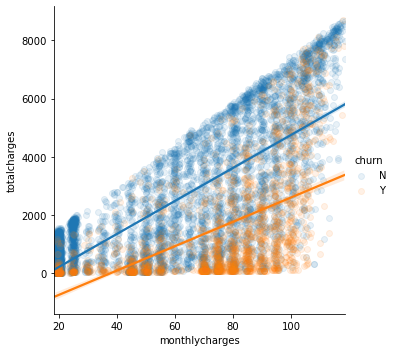

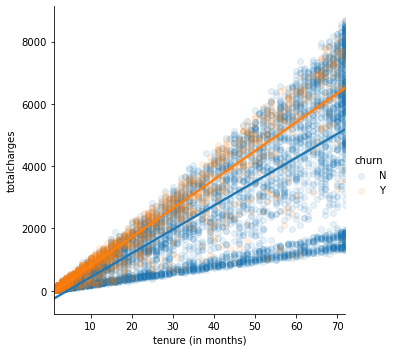

In [20]:
sns.lmplot('monthlycharges', 'totalcharges', data=df, hue='churn',
           scatter_kws={'alpha': 0.1})
fig = sns.lmplot('tenure', 'totalcharges', data=df, hue='churn',
                 scatter_kws={'alpha': 0.1})
fig.set_xlabels('tenure (in months)');

<a id="correlation-between-qualitative/-categorical-variables"></a>
## 2.2.  Correlation between Qualitative/ Categorical variables
`Cramer's V` is more appropriate than Pearson correlation to find correlation between two nominal variables. Here, the `Cramer's V` metric is implemented.

In [21]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [22]:
def categorical_corr_matrix(df):
    """
        Computes corrected Cramer's V statistic between
        all the categorical variables in the dataframe
    """
    df = df.select_dtypes(include='category')
    cols = df.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            df_crosstab = pd.crosstab(df[col1], df[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(df_crosstab)
    
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

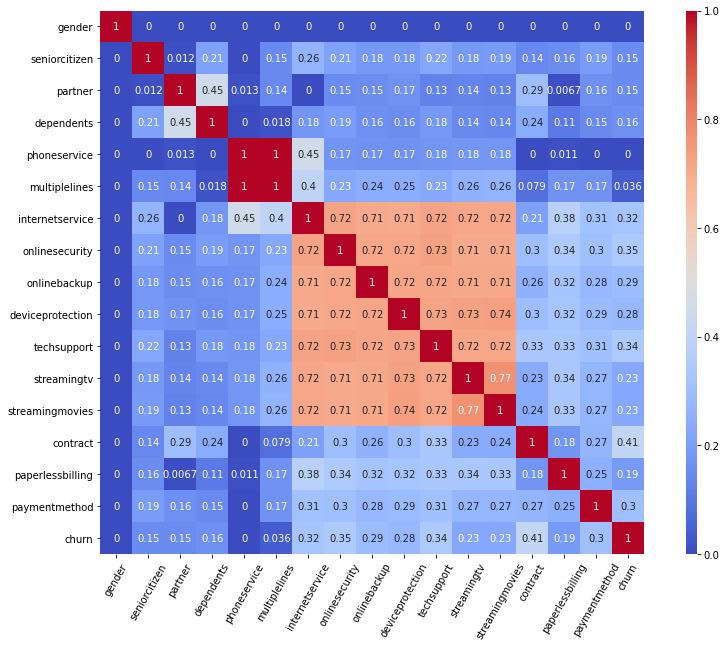

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(categorical_corr_matrix(df), annot=True, cmap='coolwarm', 
            cbar_kws={'aspect': 50}, square=True, ax=ax)
plt.xticks(rotation=60);

***Inference:*** There is some correlation between *'phone service'* and *'multiple lines'* since those who don't have a phone service cannot have multiple lines. So, knowing that a particular customer is not subscribed to phone service we can infer that the customer doesn't have multiple lines. Similarly, there is also a correlation between *'internet service'* and *'online security', 'online backup', 'device protection', 'streaming tv'* and *'streaming movies'*

<a id="data-visualization"></a>
# 3.  Data Visualization

<a id="frequency-distribution%3A-categorical-variables"></a>
## 3.1.  Frequency distribution: categorical variables

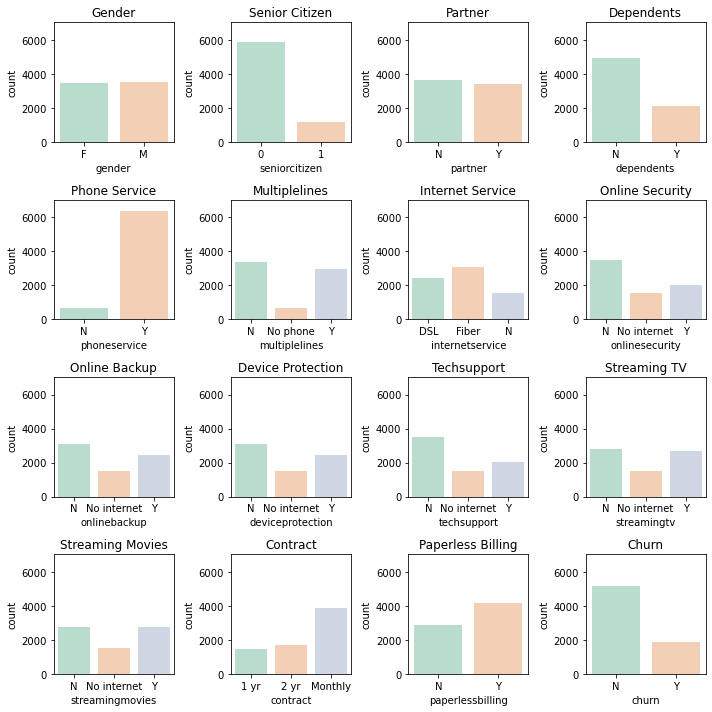

In [24]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
titles = ['Gender', 'Senior Citizen', 'Partner', 'Dependents',
          'Phone Service', 'Multiplelines', 'Internet Service', 'Online Security',
          'Online Backup', 'Device Protection', 'Techsupport', 'Streaming TV',
          'Streaming Movies', 'Contract', 'Paperless Billing', 'Churn']

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.countplot(x=''.join(title.lower().split()), data=df, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 7032)

plt.tight_layout()

<a id="frequency-distribution%3A-monthlycharges-and-tenure"></a>
## 3.2.  Frequency distribution: monthlycharges and tenure

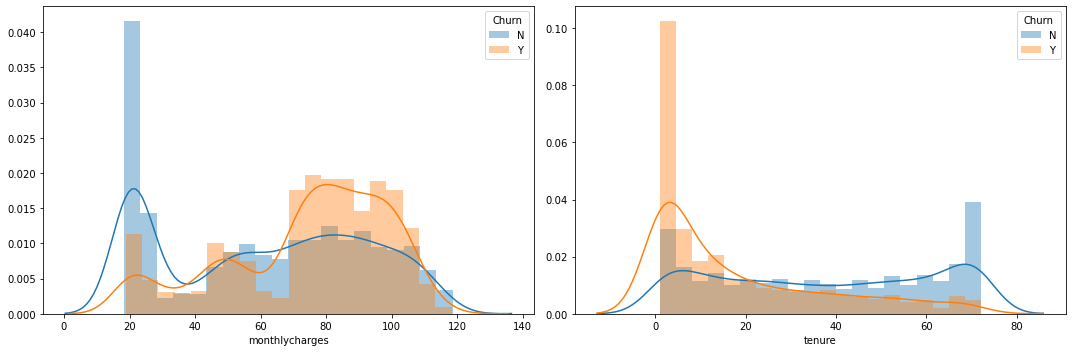

In [25]:
df_grouped = df.groupby(by='churn')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
cols = ['monthlycharges', 'tenure']
for i in range(len(cols)):
    sns.distplot(df_grouped.get_group('N')[cols[i]], bins=20, ax=axes[i], label='N')
    sns.distplot(df_grouped.get_group('Y')[cols[i]], bins=20, ax=axes[i], label='Y')
    axes[i].legend(title='Churn')

fig.tight_layout()

***Inference:*** We can say that most churn customers have monthly charges of around 70 to 110 and a tenure of around 0 to 20 months.

<a id="box-plots"></a>
## 3.3.  Box Plots

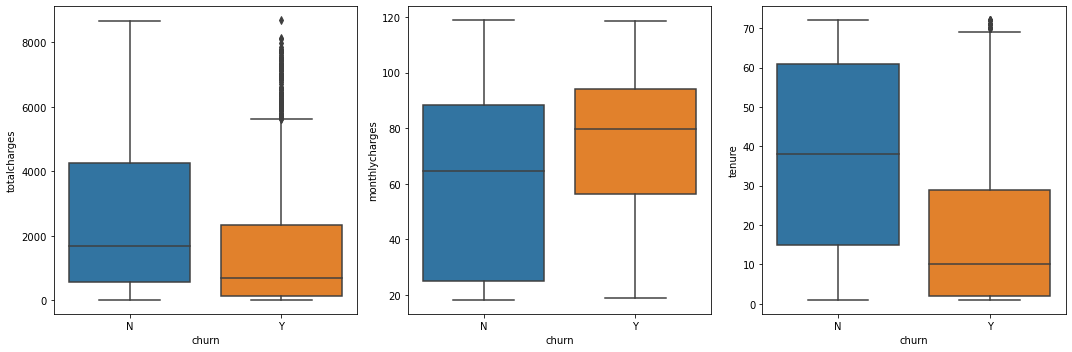

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
cols = ['totalcharges', 'monthlycharges', 'tenure']
for i in range(len(cols)):
    sns.boxplot(x='churn', y=cols[i], data=df, ax=axes[i])
fig.tight_layout()

<a id="contribution-to-churned-revenue"></a>
## 3.4.  Contribution to churned revenue
Following graph represents percent contributed by customers in each tenure bin to the lost/ churned revenue.

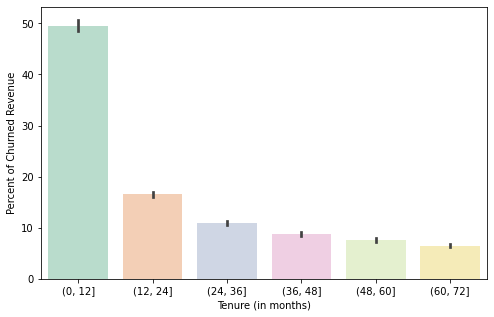

In [27]:
churned_users = df_grouped.get_group('Y')
bins = [(0, 12), (12, 24), (24, 36), (36, 48), (48, 60), (60, 72)]
binned_tenure = pd.cut(list(churned_users['tenure']),
                       bins=pd.IntervalIndex.from_tuples(bins))
revenue_share = churned_users['monthlycharges'] / churned_users['monthlycharges'].sum()
temp_df = pd.DataFrame(data={'tenure':binned_tenure, 
                             'revenue_share(%)': revenue_share * 100})


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
sns.barplot(x='tenure', y='revenue_share(%)', data=temp_df,
            estimator=np.sum, palette='Pastel2', ax=ax)
ax.set_xlabel('Tenure (in months)')
ax.set_ylabel('Percent of Churned Revenue');

***Inference:*** Within the churned customers, 50% of the churned revenue is contributed by short tenure customers. This also means that the monthly charges of short tenure customers are more than high tenure customers. Therefore, if the ML models are successful in identifying the low tenure customers, then a major chunk of the revenue can be retained.

<a id="churn-among-different-contract-types"></a>
## 3.5.  Churn among different contract types

contract,1 yr,2 yr,Monthly
churn,,,
N,1306,1637,2220
Y,166,48,1655


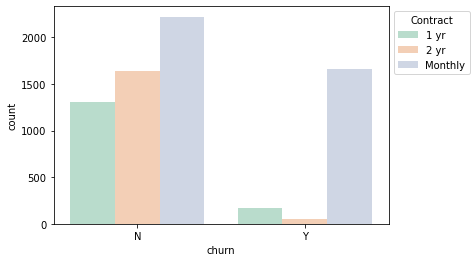

In [28]:
display(pd.crosstab(df['churn'], df['contract'], dropna=False))
sns.countplot(x='churn', hue='contract', data=df, palette='Pastel2')

# Put the legend out of the figure
plt.legend(title='Contract', bbox_to_anchor=(1, 1));

<a id="churn-among-various-categories-and-their-contribution-to-%28monthly%29-revenue"></a>
## 3.6.  Churn among various categories and their contribution to (monthly) revenue

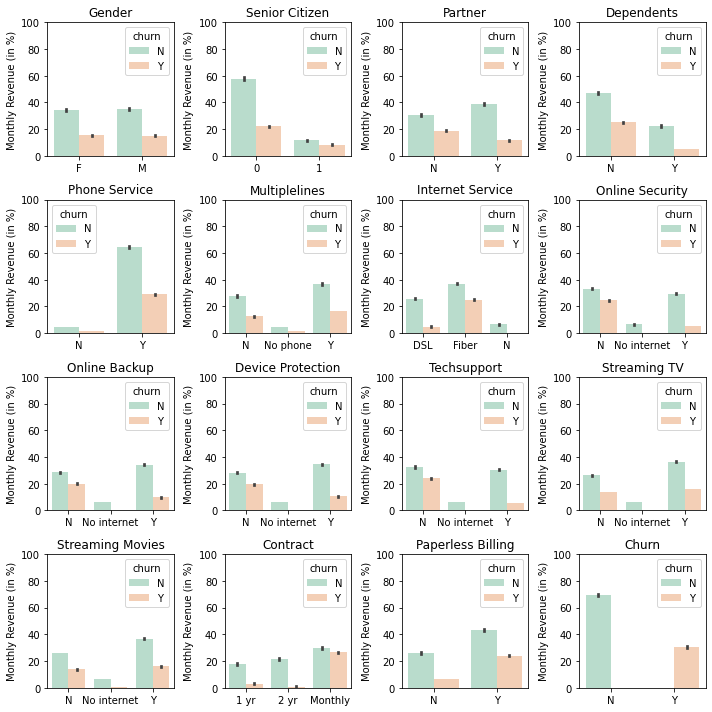

In [29]:
## Adding new column to the dataframe temporarily
# When the dataframe is grouped later, the estimator in `barplot`
# will give groupwise revenue share
df['share'] = (df['monthlycharges'] * 100) / df['monthlycharges'].sum()

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
titles = ['Gender', 'Senior Citizen', 'Partner', 'Dependents',
          'Phone Service', 'Multiplelines', 'Internet Service', 'Online Security',
          'Online Backup', 'Device Protection', 'Techsupport', 'Streaming TV',
          'Streaming Movies', 'Contract', 'Paperless Billing', 'Churn']

## axs.flat is an attribute and contains a flattened axs vector/ list
ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.barplot(x=''.join(title.lower().split()), y='share', hue='churn', data=df,
                estimator=np.sum, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 100)
    ax.set_xlabel('')
    ax.set_ylabel('Monthly Revenue (in %)')

fig.tight_layout()

***Inference:*** We can say that majority of the churned customers are not senior citizens, have dependents, are subscribed to phone service, Fiber internet, and paperless billing, are not subscribed to online security and tech support, and have monthly contracts.

In [30]:
## Remove the 'share' column
df.drop(labels=['share'], axis=1, inplace=True)

# 4. Data Preprocessing
#### Data needs to be one-hot-encoded before applying machine learning models.

In [33]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [35]:
train_cats(df)

In [42]:
def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
        
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


In [43]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [44]:
df_trn, y_trn, nas = proc_df(df, 'churn')

* Out of the 7043, 1410 entries are made into a validation set.
* The remaining are made into a training set.

In [45]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 1410
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df, n_trn)

# 5. Modeling

* We use a Random Forest Classifier to train a model on the given data.
* It is an ensemble tree-based learning algorithm. The Random Forest Classifier is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object.

In [46]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [47]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.25514973526660156, 0.4464199593900837, 0.9348986125933831, 0.800709219858156, 0.8006047669868375]


In [53]:
def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [54]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 321 ms, sys: 151 ms, total: 472 ms
Wall time: 827 ms


(0.46, 0.49839743177508444)

## Feature Importance

* Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.
* Then we take the features which are more important and make a different dataset consisting of only those features.

In [55]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [56]:
fi = rf_feat_importance(m,df_trn); fi[:10]

,cols,imp
17,monthlycharges,0.185373
18,totalcharges,0.173018
13,contract,0.151174
16,tenure,0.141147
7,onlinesecurity,0.063022
10,techsupport,0.058253
15,paymentmethod,0.037512
6,internetservice,0.025654
0,gender,0.022955
14,paperlessbilling,0.022873


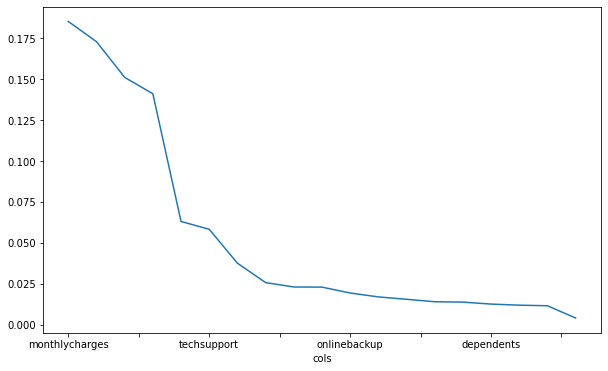

In [57]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

In [58]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

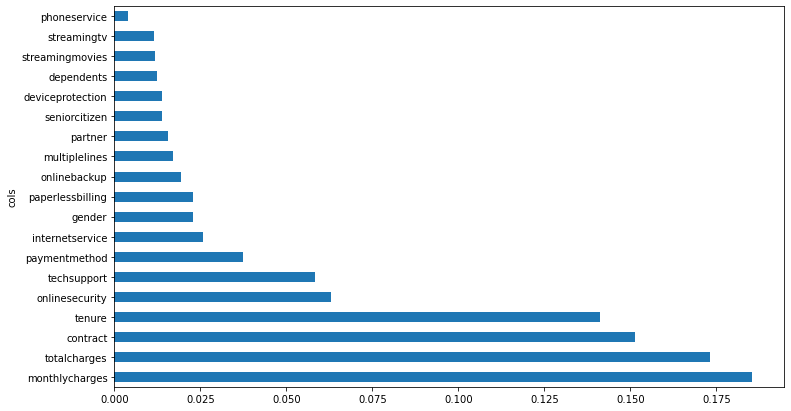

In [59]:
plot_fi(fi[:30])

In [60]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)

6

In [61]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [62]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.3099213244054658, 0.45585240861458254, 0.9039487726787621, 0.7921985815602837, 0.783706865884027]


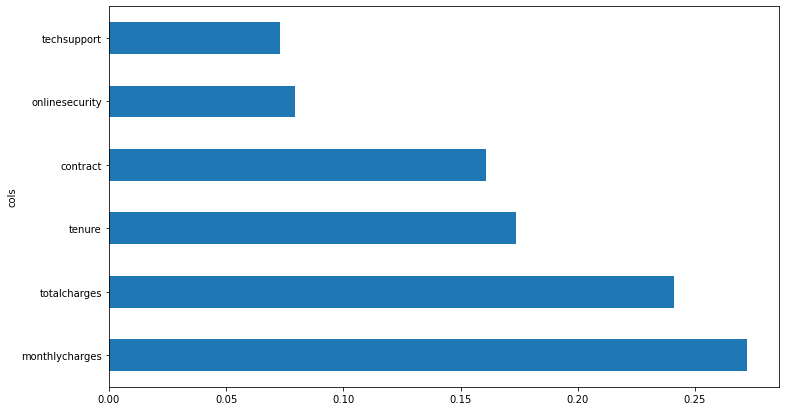

In [63]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One hot encoding

* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. 
* Here, we one-hot-encode the features whose categories are less than 7.

In [64]:
df_trn2, y_trn, nas = proc_df(df, 'churn', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2561932968213245, 0.45194614629282565, 0.9343649946638207, 0.7957446808510639, 0.7947349697616507]


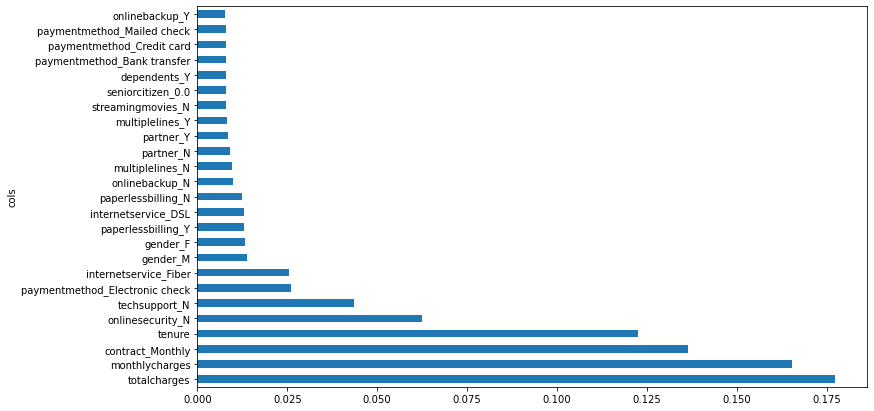

In [65]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25])

In [66]:
fi = rf_feat_importance(m,df_trn2); fi[:40]

,cols,imp
2,totalcharges,0.177381
1,monthlycharges,0.165338
52,contract_Monthly,0.136386
0,tenure,0.122604
26,onlinesecurity_N,0.062347
38,techsupport_N,0.043627
59,paymentmethod_Electronic check,0.025961
23,internetservice_Fiber,0.025473
4,gender_M,0.013789
3,gender_F,0.013352


In [67]:
to_keep2 = fi[fi.imp>0.002].cols
len(to_keep2)

39

In [68]:
df_keep2 = df_trn2[to_keep2].copy()
X_train, X_valid = split_vals(df_keep2, n_trn)

In [69]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.25128626769394824, 0.4527300950976113, 0.9368552116684454, 0.7950354609929078, 0.8023834934187122]


# Therefore the accuracy of the Random Forest Classifier on the Validation set is 79.5% and an OOB (out-of-bag) score of 80.2 %.
#### The out-of-bag (OOB) error is the average error for each calculated using predictions from the trees that do not contain in their respective bootstrap sample. This allows the RandomForestClassifier to be fit and validated whilst being trained 1.

## Tree Interpreter

The treeinterpreter library in Python allows us to compute exactly the impact of each feature for a Random Forest model.

In [70]:
pip install treeinterpreter

Note: you may need to restart the kernel to use updated packages.


In [71]:
from treeinterpreter import treeinterpreter as ti

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [72]:
df_train, df_valid = split_vals(df_trn2[df_keep2.columns], n_trn)

In [73]:
row = X_valid.values[None,0]; row

array([[78.25, 25.  ,  1.  ,  3.  ,  1.  ,  1.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  1.  ,  1.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         1.  ,  1.  ,  0.  ]])

In [74]:
prediction, bias, contributions = ti.predict(m, row)
prediction[0], bias[0]

(array([0.54349805, 0.45650195]), array([0.73528237, 0.26471763]))

In [75]:
idxs = np.argsort(contributions[0])
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


[(array(['monthlycharges', 'totalcharges'], dtype=object),
  array([78.25, 25.  ]),
  array([[-0.12491538,  0.12491538],
         [ 0.04271553, -0.04271553]])),
 (array(['totalcharges', 'monthlycharges'], dtype=object),
  array([25.  , 78.25]),
  array([[ 0.04271553, -0.04271553],
         [-0.12491538,  0.12491538]])),
 (array(['monthlycharges', 'totalcharges'], dtype=object),
  array([78.25, 25.  ]),
  array([[-0.12491538,  0.12491538],
         [ 0.04271553, -0.04271553]])),
 (array(['monthlycharges', 'totalcharges'], dtype=object),
  array([78.25, 25.  ]),
  array([[-0.12491538,  0.12491538],
         [ 0.04271553, -0.04271553]])),
 (array(['monthlycharges', 'totalcharges'], dtype=object),
  array([78.25, 25.  ]),
  array([[-0.12491538,  0.12491538],
         [ 0.04271553, -0.04271553]])),
 (array(['monthlycharges', 'totalcharges'], dtype=object),
  array([78.25, 25.  ]),
  array([[-0.12491538,  0.12491538],
         [ 0.04271553, -0.04271553]])),
 (array(['totalcharges', 'monthlyc